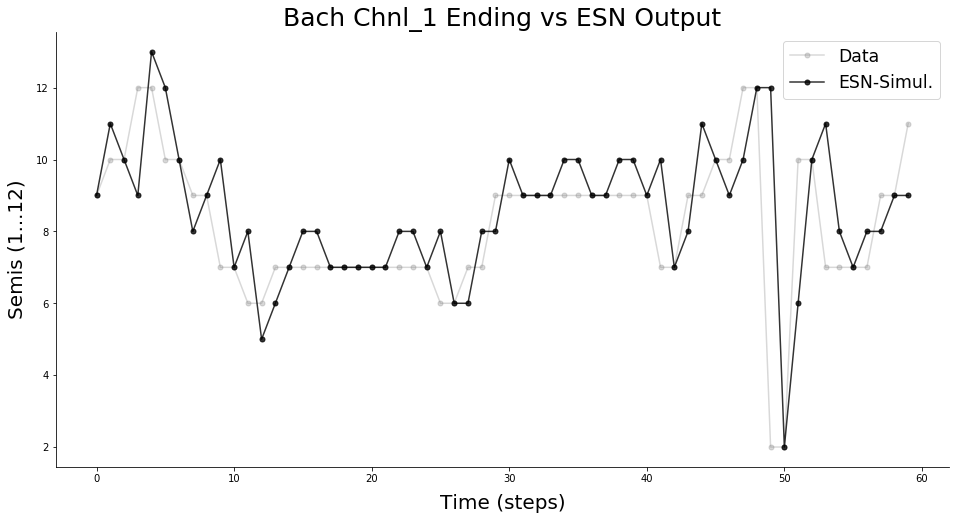

In [4]:
esn = ESN(n_inputs = Input_dim,
          n_outputs = Output_dim, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = rho_opt,
          ridge_param=ridge_opt,
          noise=noise_opt,
#         silent=False,
          leak_rate=0.7,
          teacher_forcing=True
         )
pred_training = esn.fit(tr_input,tr_output)
pr_output = esn.predict(ts_input)

plt.figure(figsize=(16,8))
plt.plot(range(0,len(ts_output)),ts_output,'b',label="Data", alpha=0.3, marker = 'o', ms = 5,color="gray")
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
pr_output=pr_output.astype(int)+1
plt.plot(range(0,len(pr_output)),pr_output,'k',  alpha=0.8, label='ESN-Simul.', marker = 'o', ms = 5,color="black")

plt.title(r'Bach Chnl_1 Ending vs ESN Output', fontsize=25)
plt.xlabel(r'Time (steps)', fontsize=20,labelpad=10)
plt.ylabel(r'Semis (1...12)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
import warnings

# This is the library for the Reservoir Computing wrap it by: https://github.com/cknd/pyESN 
# + Ridge par. + leaky decay
from pyESN import ESN 
%matplotlib inline

warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def note_number_to_semis(note_number):
    semis = np.linspace(1, 12, num=12)
    note_number = int(np.round(note_number))
    return semis[note_number % 12]

def note_number_to_octave(note_number):
    semis = np.linspace(1, 12, num=12)
    note_number = int(np.round(note_number))
    return (note_number//12 )

# with two dims
bach = np.loadtxt( 'B.txt' ).T
print(bach.shape)

bach=np.array(flatten(bach))
bach_len=len(bach)
# bach = note_number_to_name(bach)
# bach

oct_sem=np.zeros((bach_len,2))
for i in range(bach_len):
    oct_sem[i,0]=note_number_to_octave(bach[i])
#     oct_sem[i,1]=bach[i]
    oct_sem[i,1]=note_number_to_semis(bach[i])

#     if sem_oct[i,0] == 0.:
#         sem_oct[i,1]=0.
#     else:
#         sem_oct[i,1]=note_number_to_semis(bach[i])

dat_tr=np.array(flatten(oct_sem)).reshape(4, 3824*2)[0]

## set up input output
trainlen = 20
Input_dim = trainlen-2
Output_dim = 1

seq = dat_tr
window_size = trainlen

steps=len(seq) - window_size 
m=np.zeros((int(steps/2),trainlen))

for i in range(steps): 
    if i % 2 == 0:
#         print("st=",i)
        j = int(i/2)
#         print("j=",j)
        m[j,:]=seq[i: i + window_size]

output = m[:,-1].reshape(-1, 1) # currently only predict sem
input = m[:,0:-2]

print(input.shape)
print(output.shape)
input

n_test = 100
last = -40
tr_input = input[0:-n_test]
tr_output = output[0:-n_test]
ts_input = input[-n_test:last]
ts_output = output[-n_test:last]

# odd_num=octave, even_num=semis

(4, 3824)
(3814, 18)
(3814, 1)


In [3]:
#################################################

def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

n_reservoir= 500
sparsity   = 0.2
rand_seed  = 23
radius_set = [0.99]
# radius_set = np.linspace(0.5, 0.99, num=5)
# ridge_set = np.linspace(0.001, 0.99, num=5)
ridge_set = [0.001]
noise_set = np.linspace(0.0, 0.9, num=5)
# noise_set = [ 0.00001 ]

radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)
ridge_set_size = len(ridge_set)

loss = np.zeros([radius_set_size, noise_set_size,ridge_set_size,])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]
        for k in range(ridge_set_size):
            ridge_param = ridge_set[k]
        
            esn = ESN(n_inputs = Input_dim,
                  n_outputs = Output_dim, 
                  n_reservoir = n_reservoir,
                  sparsity=sparsity,
                  random_state=rand_seed,
                  spectral_radius = rho,
                  ridge_param=ridge_param,
                  noise=noise,
#                   silent=False,
                  leak_rate=0.7,
                  teacher_forcing=True
                 )
            pred_training = esn.fit(tr_input,tr_output)
            pr_output = esn.predict(ts_input)
            loss[l, j, k] = MSE(pr_output, ts_output)        
            print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', ridge = ', ridge_set[k], ', MSE = ', loss[l][j][k] )
        
        
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
ridge_opt = ridge_set[int(index_min[2])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nridge = ',ridge_opt,'\nMSE = ',minLoss)


rho =  0.99 , noise =  0.0 , ridge =  0.001 , MSE =  6783.317098341145
rho =  0.99 , noise =  0.225 , ridge =  0.001 , MSE =  2.8052503438869794
rho =  0.99 , noise =  0.45 , ridge =  0.001 , MSE =  2.7392276930394313
rho =  0.99 , noise =  0.675 , ridge =  0.001 , MSE =  2.721538365668514
rho =  0.99 , noise =  0.9 , ridge =  0.001 , MSE =  2.711300740272129
The optimal set is:
spectrum radius =  0.99 
noise =  0.9 
ridge =  0.001 
MSE =  2.711300740272129


In [2]:
# # with one dim.
# bach = np.loadtxt( 'B.txt' ).T
# print(bach.shape)

# bach=np.array(flatten(bach))
# bach_len=len(bach)
# # bach = note_number_to_name(bach)
# # bach

# sem_oct=np.zeros(bach_len)
# for i in range(bach_len):
#     if note_number_to_octave(bach[i]) == 0:
#         sem_oct[i]=0
#     else:
#         sem_oct[i]=note_number_to_semis(bach[i])
        
            
# #     sem_oct[i,1]=

# dat_tr=np.array(sem_oct).reshape(4, 3824)[0]

# ## set up input output
# trainlen = 50
# seq = dat_tr
# window_size = trainlen

# steps=len(seq) - window_size# + 1
# m=np.zeros((int(steps),trainlen))

# for i in range(steps): 
#     m[i,:]=seq[i: i + window_size]

# output = m[:,-1].reshape(-1, 1) # currently only predict sem
# input = m[:,0:-1]

# print(input.shape)
# print(output.shape)